In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/colab_files/birdsgood/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
if not os.path.exists('birds21wi'):
    !mkdir birds21wi
    os.chdir('birds21wi')
    !wget https://pjreddie.com/media/files/birds/train.tar
    !wget https://pjreddie.com/media/files/birds/test.tar
    !wget https://pjreddie.com/media/files/birds/names.txt
    !tar xf train.tar
    !tar xf test.tar
    !mkdir testing
    !mv test testing
    os.chdir('..')

In [ ]:
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.Resize(128),
        transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.RandomCrop(128, padding=8, padding_mode='edge'),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(),
    ])
    trainset = torchvision.datasets.ImageFolder(root='birds21wi/train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='birds21wi/testing', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    classes = open("birds21wi/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

In [ ]:
print(data['to_class'])

{0: 0, 1: 1, 2: 10, 3: 100, 4: 101, 5: 102, 6: 103, 7: 104, 8: 105, 9: 106, 10: 107, 11: 108, 12: 109, 13: 11, 14: 110, 15: 111, 16: 112, 17: 113, 18: 114, 19: 115, 20: 116, 21: 117, 22: 118, 23: 119, 24: 12, 25: 120, 26: 121, 27: 122, 28: 123, 29: 124, 30: 125, 31: 126, 32: 127, 33: 128, 34: 129, 35: 13, 36: 130, 37: 131, 38: 132, 39: 133, 40: 134, 41: 135, 42: 136, 43: 137, 44: 138, 45: 139, 46: 14, 47: 140, 48: 141, 49: 142, 50: 143, 51: 144, 52: 145, 53: 146, 54: 147, 55: 148, 56: 149, 57: 15, 58: 150, 59: 151, 60: 152, 61: 153, 62: 154, 63: 155, 64: 156, 65: 157, 66: 158, 67: 159, 68: 16, 69: 160, 70: 161, 71: 162, 72: 163, 73: 164, 74: 165, 75: 166, 76: 167, 77: 168, 78: 169, 79: 17, 80: 170, 81: 171, 82: 172, 83: 173, 84: 174, 85: 175, 86: 176, 87: 177, 88: 178, 89: 179, 90: 18, 91: 180, 92: 181, 93: 182, 94: 183, 95: 184, 96: 185, 97: 186, 98: 187, 99: 188, 100: 189, 101: 19, 102: 190, 103: 191, 104: 192, 105: 193, 106: 194, 107: 195, 108: 196, 109: 197, 110: 198, 111: 199, 112

torch.Size([8, 3, 128, 128])


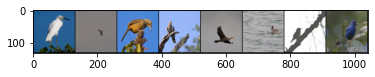

Labels:Snowy Egret, Violet-green Swallow, California Thrasher, White-winged Dove, Double-crested Cormorant (Immature), Eared Grebe (Nonbreeding/juvenile), Red-breasted Nuthatch, Indigo Bunting (Adult Male)


In [ ]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

In [ ]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

In [ ]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 9            |        cudaMalloc retries: 9         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  685726 KB |   14039 MB |    3888 GB |    3887 GB |\n|       from large pool |  617048 KB |   14009 MB |    2418 GB |    2418 GB |\n|       from small pool |   68678 KB |      99 MB |    1469 GB |    1469 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |  685726 KB |   14039 MB |    3888 GB |    3887 GB |\n|       from large pool |  617048 KB |   14009 MB |

In [ ]:
resnext = torch.hub.load('pytorch/vision:v0.9.0', 'resnext50_32x4d', pretrained=True)
resnext.fc = nn.Linear(resnext.fc.in_features, 555)
#checkpoints = '/content/drive/MyDrive/colab_files/birds/'
#state = torch.load(checkpoints+'checkpoint-18.pkl')
#losses = train(resnext, data['train'], epochs=24, state = state, schedule={0:.1, 3:.01, 13:.001, 20:.0001}, checkpoint_path=checkpoints)
losses = train(resnext, data['train'], epochs=53, schedule={0:.15, 10:.1, 30:.01, 45:.001, 51:.0001}, checkpoint_path=checkpoints)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Learning rate: 0.150000
[0,    10] loss: 7.158
[0,    20] loss: 7.676
[0,    30] loss: 7.144
[0,    40] loss: 6.835
[0,    50] loss: 6.566
[0,    60] loss: 6.427
[0,    70] loss: 6.405
[0,    80] loss: 6.341
[0,    90] loss: 6.316
[0,   100] loss: 6.328
[0,   110] loss: 6.321
[0,   120] loss: 6.298
[0,   130] loss: 6.306
[0,   140] loss: 6.302
[0,   150] loss: 6.306
[0,   160] loss: 6.280
[0,   170] loss: 6.298
[0,   180] loss: 6.292
[0,   190] loss: 6.281
[0,   200] loss: 6.291
[0,   210] loss: 6.300
[0,   220] loss: 6.315
[0,   230] loss: 6.293
[0,   240] loss: 6.278
[0,   250] loss: 6.302
[0,   260] loss: 6.293
[0,   270] loss: 6.280
[0,   280] loss: 6.285
[0,   290] loss: 6.288
[0,   300] loss: 6.283
[0,   310] loss: 6.299
[0,   320] loss: 6.306
[0,   330] loss: 6.292
[0,   340] loss: 6.292
[0,   350] loss: 6.278
[0,   360] loss: 6.288
[0,   370] loss: 6.278
[0,   380] loss: 6.275
[0,   390] loss: 6.257
[0,   400] loss: 6.255
[0,   410] loss: 6.261
[0,   420] loss: 6.211
[0,   430]

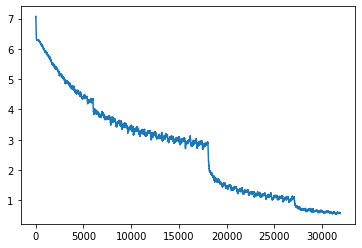

In [ ]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')
plt.plot(smooth(losses,50))

In [ ]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

In [ ]:
for i in range(10):
    predict(resnext, data['test'], "preds" + str(i)+".csv")
path = './'
sum = []
for i in range(10):
    name = 'preds'+str(i)+'.csv'
    datasf = pd.read_csv(path+name,usecols=['path','class'],nrows=10000)
    datas = datasf.loc[:,'class']
    class_num = []
    for s in datas:
        class_num.append(s)
    sum.append(class_num)

samplefiles = datasf.loc[:,'path']
samples = []
for s in samplefiles:
    samples.append(s)

sum = np.array(sum, dtype='int')
out = open(path + 'preds.csv', 'w')
out.write("path,class\n")

for i in range(10000):
    binc = np.bincount(sum[:,i])
    pred = np.argmax(binc)
    fname = samples[i]
    out.write("test/{},{}\n".format(fname.split('/')[-1], pred))
out.close()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
0
100
200
300
400
500
60